In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/'My Drive'/Code/ImagesProcessing

In [ ]:
!pip install opencv-contrib-python==4.4.0.44
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
print (cv2.__version__)

In [ ]:
def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

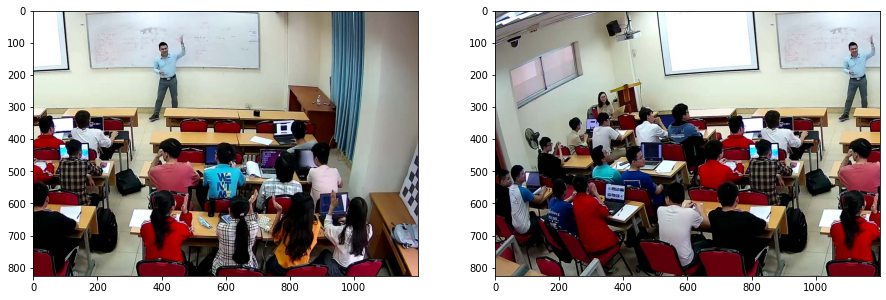

In [ ]:
# src_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
# tar_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

src_img = imageio.imread('./images/2.jpg')
tar_img = imageio.imread('./images/1.jpg')


src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)

plot_imgs([src_img, tar_img], size=8)

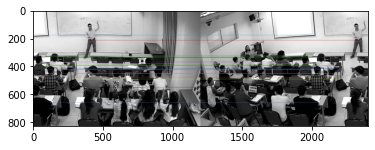

type of keypoint (3.7070250511169434, 460.02288818359375)
shape of descriptor (4438, 128)


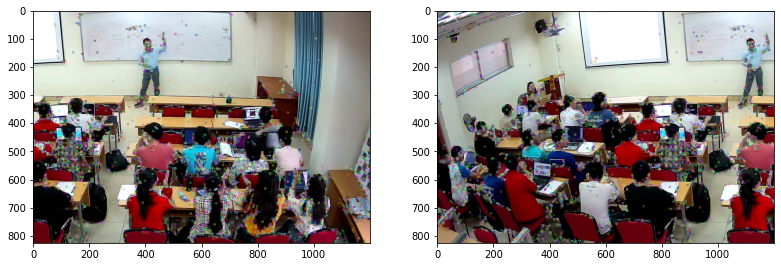

In [ ]:
detect_by="sift" # "orb"
if detect_by == "sift":
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(src_gray, None)
    kp2, des2 = sift.detectAndCompute(tar_gray, None)
    bf = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=False)
elif detect_by is "orb":
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(src_gray,None)
    kp2, des2 = orb.detectAndCompute(tar_gray,None)
    bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=False)
else:
    bf=None
    
matches = bf.match(des1,des2)
# matches = bf.knnMatch(des1, des2, 2)
matches = sorted(matches, key = lambda x:x.distance)
result = cv2.drawMatches(src_gray,kp1,tar_gray,kp2,matches[:20],None, flags=2)
plt.imshow(result)
plt.show()

print ("type of keypoint",kp1[1].pt)
print("shape of descriptor", des1.shape)
plot_imgs([
    cv2.drawKeypoints(src_img, kp1, None),
    cv2.drawKeypoints(tar_img, kp2, None)
])


## Match keypoint

type of matches <class 'cv2.DMatch'>


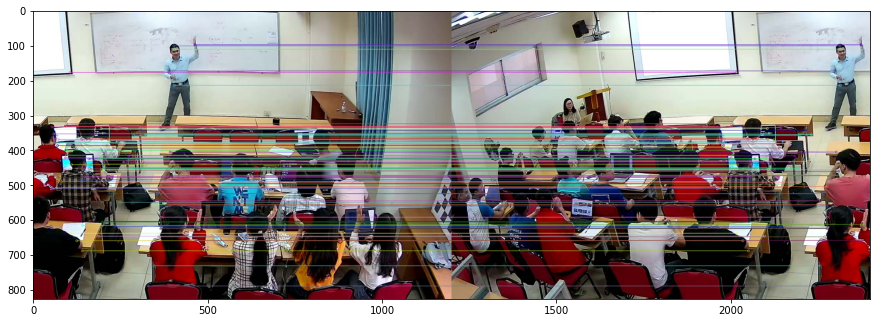

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list gồm k ứng viên cho mỗi keypoint. 
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75
print ("type of matches", type(rawMatches[1][1]))
for m,n in rawMatches:
    # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
    if m.distance < n.distance * ratio:
        matches.append(m)

# do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:100]

img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_img(img3, size=(15, 10))

## Nhìn vào hình dưới đây, ta thấy các cặp Keypoint giữa 2 ảnh đã được match khá chính xác, số điểm nhiễu không quá nhiều

## Estimate Homography matrix and Transform Image

In [ ]:
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])
# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)

[[ 9.99866055e-01  1.11316734e-04  7.10007093e+02]
 [-1.68480012e-05  1.00002725e+00  9.02736905e-03]
 [-2.09348240e-07  1.70056622e-07  1.00000000e+00]]


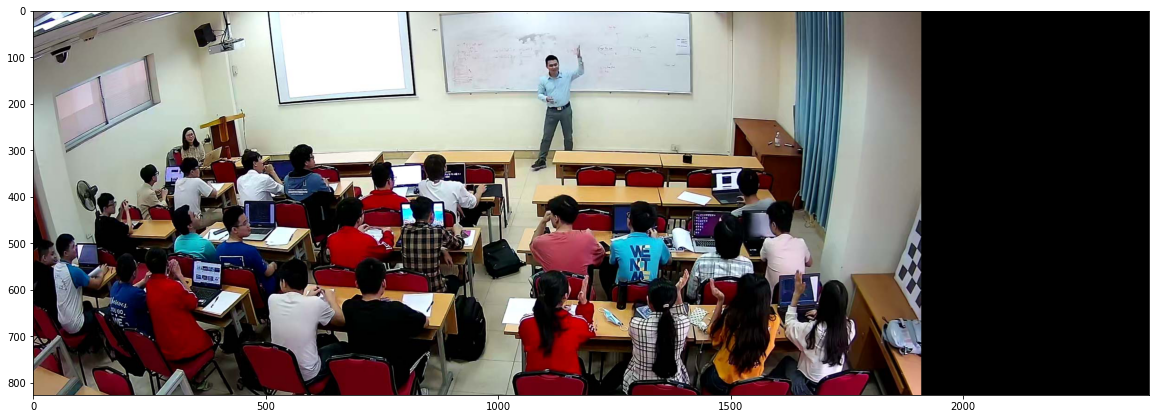

In [ ]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]

result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img

plot_img(result, size=(20,10))